# CLIP Zero‑Shot Multi‑Label Classification — Rare Traffic Classes

Project exploring **zero‑shot multi‑label** recognition with **CLIP** on a small, imbalanced traffic dataset.
I only had **~100 labeled training images**, so the approach uses **prompt engineering**, **patch‑level scoring**, and
**class‑specific threshold calibration** instead of full supervised training.

**Headline result:** Mean Balanced Accuracy (train split) ≈ **65%** with pure zero‑shot CLIP + calibrated thresholds.

**What this notebook shows**
- Data prep and patch extraction for large frames
- CLIP text–image scoring with descriptive prompts (2–5 per class)
- Threshold calibration per class for multi‑label decisions
- Metrics & qualitative analysis, with clear next steps

## Dataset
The dataset includes traffic-related objects such as barricades, police cars, and construction equipment, with multiple labels possible per image.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from utils.data import load_image_data, load_labels_and_classes, split_images_into_train_test, sort_labels

IMAGE_DIR = "data/2ndFloorData/2ndFloorData/images"
LABEL_FILE = "data/2ndFloorData/2ndFloorData/provided_labels.json"
CLASSES_FILE = "data/2ndFloorData/2ndFloorData/classes.json"

image_file_paths = load_image_data(IMAGE_DIR)
labels, classes = load_labels_and_classes(LABEL_FILE, CLASSES_FILE)
labels = sort_labels(labels)

train_images, test_images = split_images_into_train_test(image_file_paths, labels)

In [6]:
print("Total images found:", len(image_file_paths))
print("First 5 image filenames:", image_file_paths[:5])

Total images found: 1002
First 5 image filenames: ['L2ndFloor-D-2022-02-27_T-00_00_01', 'L2ndFloor-D-2022-03-27_T-18_00_01', 'L2ndFloor-D-2022-03-21_T-00_00_01', 'L2ndFloor-D-2022-02-20_T-03_00_01', 'L2ndFloor-D-2022-03-06_T-03_00_01']


In [7]:
print("Total labeled images:", len(labels))
print("First 5 labeled images:", list(labels.items())[:5])
print("Total classes:", len(classes))
print("Class names:", classes)

Total labeled images: 100
First 5 labeled images: [('L2ndFloor-D-2021-12-22_T-22_00_01', {'image_nr': 0, 'labels': [0, 2, 3]}), ('L2ndFloor-D-2021-12-23_T-18_30_01', {'image_nr': 1, 'labels': [2, 3]}), ('L2ndFloor-D-2021-12-22_T-22_30_01', {'image_nr': 2, 'labels': [0, 2, 3]}), ('L2ndFloor-D2020-06-17_T12-29-34', {'image_nr': 3, 'labels': []}), ('L2ndFloor-D-2021-12-23_T-00_00_01', {'image_nr': 4, 'labels': [0, 2, 3]})]
Total classes: 14
Class names: {'0': 'barricade', '1': 'traffic cone', '2': 'traffic barrel', '3': 'scaffold', '4': 'trailer truck', '5': 'police car', '6': 'ambulance', '7': 'firecar', '8': 'excavator', '9': 'construction truck', '10': 'car moving truck', '11': 'offroad parking', '12': 'construction car', '13': 'construction worker'}


In [8]:
print("First 5 sorted labels:", list(labels.items())[:5])

First 5 sorted labels: [('L2ndFloor-D-2021-12-22_T-22_00_01', {'image_nr': 0, 'labels': [0, 2, 3]}), ('L2ndFloor-D-2021-12-23_T-18_30_01', {'image_nr': 1, 'labels': [2, 3]}), ('L2ndFloor-D-2021-12-22_T-22_30_01', {'image_nr': 2, 'labels': [0, 2, 3]}), ('L2ndFloor-D2020-06-17_T12-29-34', {'image_nr': 3, 'labels': []}), ('L2ndFloor-D-2021-12-23_T-00_00_01', {'image_nr': 4, 'labels': [0, 2, 3]})]


In [9]:
print("Train images count:", len(train_images))
print("Test images count:", len(test_images))
print("First 5 train images:", train_images[:5])
print("First 5 test images:", test_images[:5])

Train images count: 100
Test images count: 902
First 5 train images: ['L2ndFloor-D-2022-01-30_T-18_30_01', 'L2ndFloor-D-2021-12-25_T-00_30_01', 'L2ndFloor-D-2021-12-24_T-14_30_01', 'L2ndFloor-D-2021-12-26_T-22_00_01', 'L2ndFloor-D-2022-01-21_T-14_30_01']
First 5 test images: ['L2ndFloor-D-2022-02-27_T-00_00_01', 'L2ndFloor-D-2022-03-27_T-18_00_01', 'L2ndFloor-D-2022-03-21_T-00_00_01', 'L2ndFloor-D-2022-02-20_T-03_00_01', 'L2ndFloor-D-2022-03-06_T-03_00_01']


## Evaluation

We evaluate the **multi-label** predictions by first converting the label dict to a
**multi-hot matrix** of shape **(N, C)**, where:
- **N = 100** images (train split)
- **C = 14** classes (order given by `classes`)

In [10]:
from utils.data import convert_labels_to_multi_hot_encoding

# Convert labels dict to multi-hot encoding
labels_multi_hot_encoding = convert_labels_to_multi_hot_encoding(labels, classes)

In [11]:
print("Shape of labels_multi_hot_encoding:", labels_multi_hot_encoding.shape)

Shape of labels_multi_hot_encoding: (100, 14)


In [12]:
print("First 5 rows of labels_multi_hot_encoding:\n", labels_multi_hot_encoding[:5])

First 5 rows of labels_multi_hot_encoding:
 [[1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Data Loading and Visualization 

In [13]:
from utils.data import load_image

# Dictionary to store loaded images
train_images_data = {}  
test_images_data = {}   

# Load training images
for img_name in train_images:
    image_array, processed_name = load_image(IMAGE_DIR, img_name)
    train_images_data[processed_name] = image_array  

# Load test images
for img_name in test_images:
    image_array, processed_name = load_image(IMAGE_DIR, img_name)
    test_images_data[processed_name] = image_array 

print(f"Loaded {len(train_images_data)} training images and {len(test_images_data)} test images.")

Loaded 100 training images and 902 test images.


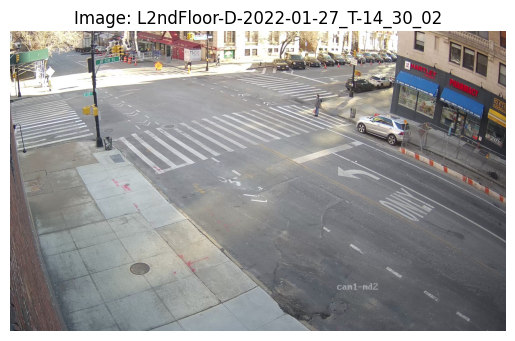

In [14]:
import matplotlib.pyplot as plt
import random

# Pick a random image from train_images_data
random_img_name = random.choice(list(train_images_data.keys()))

# Display the image
plt.imshow(train_images_data[random_img_name])
plt.title(f"Image: {random_img_name}")
plt.axis("off")
plt.show()

In [15]:
img_name = random.choice(list(train_images_data.keys()))
print(f"Shape of {img_name}: {train_images_data[img_name].shape}")

Shape of L2ndFloor-D-2021-12-26_T-00_30_01: (1860, 3080, 3)


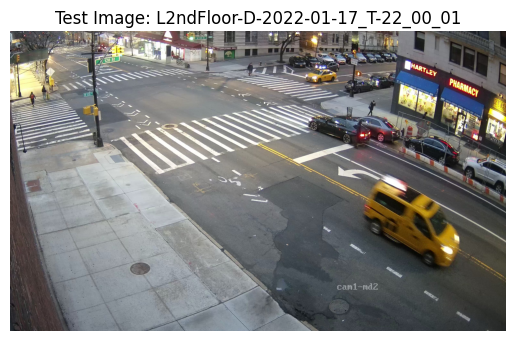

In [16]:
img_name = random.choice(list(test_images_data.keys()))  # Pick random test image
plt.imshow(test_images_data[img_name])
plt.title(f"Test Image: {img_name}")
plt.axis("off")
plt.show()

## Method
- Preprocessing and feature extraction
- Zero-shot classification with CLIP
- Evaluation metrics (mean balanced accuracy, etc.)

In [ ]:
!pip install open-clip-torch

In [ ]:
import torch
import open_clip

model_name = "ViT-H-14"
pretrained = "laion2b_s32b_b79k"
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=model_name,
    pretrained=pretrained,
    device=device
)

tokenizer = open_clip.get_tokenizer(model_name)
model.eval()

In [20]:
import torch.nn.functional as F

class_names = list(classes.values())
prompts = [f"A photo of a {name}" for name in class_names]

text_inputs = tokenizer(prompts).to(device)

# Encode text embeddings
with torch.no_grad():
    text_embeds = model.encode_text(text_inputs)
    text_embeds = F.normalize(text_embeds, dim=-1)

In [21]:
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F


def generate_patches(img_array, patch_size=224, stride=96):
    '''
    function to split input image into overlapping patches
    parameters:
    img_array: input numpy image array
    patch_size: size to crop into patches based on clip
    stride: stride based on clip
    '''
    H, W, C = img_array.shape
    patches = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            crop = img_array[y:y + patch_size, x:x + patch_size]
            patches.append(Image.fromarray(crop))
    if len(patches) == 0:
        patches = [Image.fromarray(img_array)]
    return patches

train_image_scores = {}

for img_id, img_array in tqdm(train_images_data.items()):#img_array (H, W, C)
    patches = generate_patches(img_array)
    patch_logits = []#output scores for each patch

    for i in range(0, len(patches), 32): 
        batch = patches[i:i+32]

        # Preprocess each image in the batch
        inputs = torch.stack([preprocess(img) for img in batch]).to(device)

        with torch.no_grad():
            image_feats = model.encode_image(inputs)    #encode image into feature vector          
            image_feats = F.normalize(image_feats, dim=-1)  #normalize - needed for cosine similiarity       
            logits = image_feats @ text_embeds.T        #do cosine similarity

        patch_logits.append(logits.cpu())

    all_logits = torch.cat(patch_logits, dim=0)    #tensor of output scores (num patches, num classes)   
    max_logits, _ = torch.max(all_logits, dim=0) #get max score for each class
    train_image_scores[img_id] = max_logits

100%|███████████████████████████████████████████████████████████████████████| 100/100 [1:26:00<00:00, 51.60s/it]


In [22]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score

image_ids = list(train_image_scores.keys())
logit_matrix = np.stack([train_image_scores[img_id].numpy() for img_id in image_ids])  #(num images, num classes) similarity matrxi fro class and image
label_matrix = np.array(labels_multi_hot_encoding)  #labels matrix to match with logit_matrix

best_thresholds = [] #store best threshold for each class

for class_idx in range(label_matrix.shape[1]):
    best_acc = 0
    best_thresh = 0.5

    for thresh in np.linspace(0, 1, 1000):#threshold sweep
        preds = (logit_matrix[:, class_idx] > thresh).astype(int)#logit -> binary prediciton - if predicted score is > threshold
        acc = balanced_accuracy_score(label_matrix[:, class_idx], preds)

        if acc > best_acc:#keeping best threshold
            best_acc = acc
            best_thresh = thresh

    best_thresholds.append(best_thresh)

best_thresholds = np.array(best_thresholds)  
print("Best thresholds per class:", best_thresholds)

Best thresholds per class: [0.28628629 0.36036036 0.36036036 0.24024024 0.23423423 0.25225225
 0.22822823 0.29229229 0.22522523 0.28628629 0.27327327 0.23123123
 0.29429429 0.24824825]


In [23]:
# Generate binary predictions using the best thresholds
train_preds = (logit_matrix > best_thresholds).astype(int)

In [ ]:
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

def generate_patches(img_array, patch_size=224, stride=96):
    H, W, C = img_array.shape
    patches = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            crop = img_array[y:y + patch_size, x:x + patch_size]
            patches.append(Image.fromarray(crop))
    if len(patches) == 0:
        patches = [Image.fromarray(img_array)]
    return patches
    
test_image_scores = {}

for img_id, img_array in tqdm(test_images_data.items()):
    patches = generate_patches(img_array)
    patch_logits = []#similarity score logits for each img patch

    for i in range(0, len(patches), 32): 
        batch = patches[i:i+32]
        inputs = torch.stack([preprocess(img) for img in batch]).to(device)

        with torch.no_grad():
            image_feats = model.encode_image(inputs)  #image feature map for each image patch
            image_feats = F.normalize(image_feats, dim=-1) 
            logits = image_feats @ text_embeds.T #cos similiarity

        patch_logits.append(logits.cpu())

    all_logits = torch.cat(patch_logits, dim=0) 
    max_logits, _ = torch.max(all_logits, dim=0)
    test_image_scores[img_id] = max_logits

 82%|███████████████████████████████████████████████████████▋            | 738/902 [10:34:51<2:21:10, 51.65s/it]

In [ ]:
# Ensure consistent order
test_ids = list(test_image_scores.keys())
test_logit_matrix = np.stack([test_image_scores[img_id].numpy() for img_id in test_ids]) 

# Apply thresholds
test_preds = (test_logit_matrix > best_thresholds).astype(int)

In [ ]:
print(test_preds.shape)

## Results
## Evaluate results with custom mean balanced accuracy metrics 

In [24]:
from utils.metrics import compute_balanced_accuracy

# Compute the balanced accuracy across all classes
mean_balanced_accuracy, accuracies = compute_balanced_accuracy(train_preds, labels_multi_hot_encoding)

print("Mean Balanced Accuracy (Computed over all classes):", mean_balanced_accuracy)
print('Balanced Accuracy Per Class:')
for class_idx, class_name in classes.items():
    print(f'{class_name}: {accuracies[int(class_idx)]}')

Mean Balanced Accuracy (Computed over all classes): 0.6402700857726067
Balanced Accuracy Per Class:
barricade: 0.6254295532646048
traffic cone: 0.51875
traffic barrel: 0.5263157894736842
scaffold: 0.7525252525252526
trailer truck: 0.6787538304392238
police car: 0.7368421052631579
ambulance: 0.6683848797250859
firecar: 0.734375
excavator: 0.5505952380952381
construction truck: 0.5597826086956521
car moving truck: 0.8535353535353536
offroad parking: 0.5927835051546392
construction car: 0.5368421052631579
construction worker: 0.6288659793814433


## Results & Next Steps

- **Metric:** Mean Balanced Accuracy (train split) ≈ **65%** on ~100 labeled images.
- **Observations:** Class imbalance and small objects make thresholds crucial. Prompt wording matters.
- **Limitations:** Very small labeled set → possible threshold overfitting; visually similar classes are hardest.
- **Next steps:** Gather more labels; try linear‑probe / LoRA fine‑tuning of CLIP; prompt ensembles and TTA; per‑class temperature/Platt scaling.